In [1]:
#!pip install transformers==4.12.0
#!pip install tensorflow==2.4.0
#!pip install datasets
#!pip install wandb
#!pip install langdetect

In [1]:
first_run = False

In [2]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#from google.colab import drive
from langdetect import detect
import matplotlib.dates as md

%load_ext autoreload
%autoreload 2

#drive.mount('/content/drive/')
#%cd '/content/drive/My Drive/eu_commission'

### Read in the data

In [1519]:
fs = glob.glob('data/*/*')
fields = ['text', 'lang']
metrics = [f'{m}_count' 
           for m in ['like','quote','reply','retweet']]
processed_tws = []
for f in fs:
    tws = json.load(open(f))['data']
    for i in range(len(tws)):
        item = {k: tws[i][k] for k in fields}
        item.update({k: tws[i]['public_metrics'][k] for k in metrics})
        item.update({'created_at': tws[i]['created_at'][:10]})
        tws[i] = item
    processed_tws += tws

In [1520]:
df = pd.DataFrame(processed_tws)
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)

### Tweet volume

In [319]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (50,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_volume(language='en', freqs='D', plot_smooth_only=False, roll_window=7):
    top_dict = {}
    for freq in [freqs]:
        fig, ax = plt.subplots(figsize=figsizes[freq])
        if df['created_at'].dtype != 'datetime64':
            df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
        if language=='all':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()      
        elif language=='en':
            grouped = df.groupby(pd.Grouper(key='created_at', axis=0, freq=freq)).count().reset_index()
        else:
            new_df = df.copy()
            new_df['is_other'] = np.where((new_df['lang']=='en') & (new_df['lang_detected']=='en'), 0, 1)
            counts = new_df.groupby(grouper).count().reset_index()[['created_at','text']].rename({'text': 'count'}, axis=1)
            by_lang = new_df.groupby([grouper,'is_other']).count().reset_index() 
            grouped = pd.merge(by_lang, counts, how='outer')
            grouped['text'] = np.where(grouped['count'] != 0, grouped['text'] / grouped['count'], 0)
            grouped = grouped[grouped['is_other']==1]
            grouped = grouped.fillna(0)
        top_dict[freq_dict[freq]] = grouped.sort_values(by='text', ascending=False).head(n=5)[['created_at', 'text']].to_records(index=False)
        grouped['smoothed'] = grouped['text'].rolling(roll_window).mean()
        # Plot 
        if not plot_smooth_only:
            sns.lineplot(data=grouped, x='created_at', y='text', 
                         alpha=.2, 
                         label='per day')
        sns.lineplot(data=grouped, x='created_at', y='smoothed', 
                     label=f'smoothed avg - {roll_window}d', 
                     color=sns.color_palette()[0])
        if language in ['all', 'en']:
            plt.ylabel(f'Tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Tweet volume {language.upper()}')
        else:
            plt.ylabel(f'Proportion tweets per {freq_dict[freq]}')
            plt.xlabel('')
            plt.title(f'Proportion tweets not in English')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),120), color='black')
        ax.xaxis.set_major_locator(md.MonthLocator())
        ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        if language == 'en':
            plt.savefig(f'figures/tweet_volume_EN.pdf')
        else:
            plt.savefig(f'figures/tweet_volume_others.pdf')
        plt.show()
    return top_dict

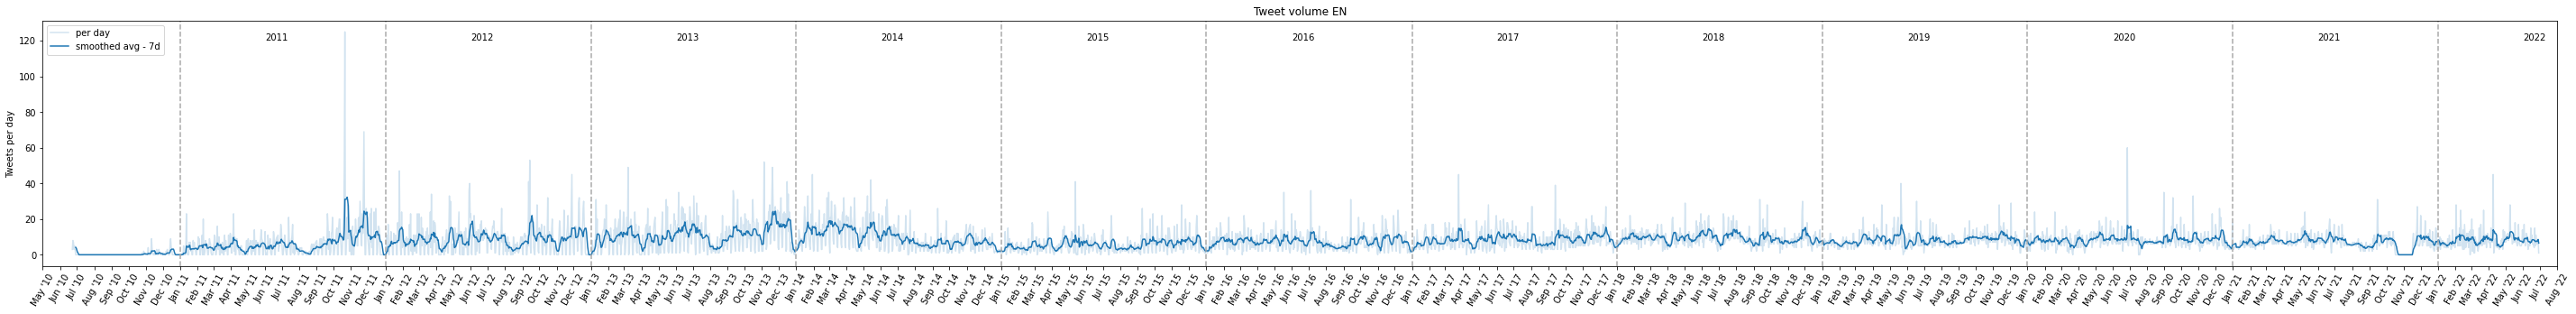

In [320]:
top_dict = plot_volume(roll_window=7)

In [321]:
print(df[df.created_at == np.datetime64(top_dict['day'][1][0])].text.tolist())
print(top_dict['day'][1][0])

['Air transport: #EC requests Austria, Germany, Italy and Luxembourg to comply with rules on airport charges  http://t.co/sVQ7iwfQ', 'Maritime safety:#EC requests #Italy to comply with new safety rules for passenger ships http://t.co/hMqNwrO7', 'Rail: #EC refers #Germany to Court of Justice over railway safety http://t.co/0Nfo9eAp', '#EC asks the #United Kingdom to pay due amounts of customs duties to #EU budget  http://t.co/qsjObEPR', 'Free movement of goods: #EC requests #Greece to facilitate the selling of "bake off" products  http://t.co/qH6GSk8m', 'Free movement of goods: #EC requests #Netherlands to comply with EU rules on firearms  http://t.co/3KCimGLY', "Working time: #EC requests #Belgium to end compulsory postponement of workers' annual leave http://t.co/U9GlQkPC", 'Free movement of workers: #EC requests #Italy to end discrimination in recruiting university professors  http://t.co/PFJGDfLI', 'Social Security: #EC requests #Spain to end refusal of European Health Insurance Car

Some of the peaks with highest volumes are related to live tweeting of #EUMFF negotiations, automated posting re: to activity on other websites (Storify), and other. 
Worth keeping in mind that tweet volume can be a major confounder with this data.

### Additional preprocessing
- flag retweets and tweets starting with mentions;
- strip links;
- not removing emojis, hashtags and mentions, for now - but could remove depending on which model we end up using;
- assign some tweet to a "pretraining" dataset

Re: this latter. Let's leave out a small dataset for pretraining of our language models. We pick a random set of tweets (if that does not show good results, we could consider balanced sampling over time).

In [322]:
def language_detection(s):
    try:
        return detect(s)
    except:
        return 'unk'

In [323]:
if first_run is True:
    
    # Preprocessing
    df['is_retweet'] = np.where(df['text'].str.startswith('RT'), 1, 0)
    df['is_mention'] = np.where(df['text'].str.startswith('@'), 1, 0)
    df['text'] = df['text'].str.replace(r'http.*', '', regex=True)
    df = df[df['text'].str.len() > 0]
    df['lang_detected'] = df['text'].apply(language_detection)
    df[df['lang']!=df['lang_detected']]
    
    # Pretraining splits
    import random
    random.seed(42)
    train_size = 3000
    val_size = 500
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * (df.shape[0] - train_size - val_size)
    random.shuffle(train_test)
    df['pretraining_splits'] = train_test
    
    # Save
    df.to_json('processed/all_tweets.jsonl', lines=True, orient='records')

Breakdown of number of tweets per language

In [1522]:
df = pd.read_json('processed/all_tweets.jsonl', lines=True, orient='records')
print(df.groupby('lang')['text'].count().reset_index().sort_values(by='text', ascending=False).rename({'text': 'count'}, axis=1))

   lang  count
7    en  32446
12   fr    828
5    de    207
8    es    155
29  und    122
17   it     81
24   ro     69
28   uk     47
22   pl     45
20   nl     37
23   pt     36
1    ca     33
6    el     29
4    da     28
9    et     23
11   fi     22
2    cs     21
26   sv     19
0    bg     16
15   in     12
19   lv     10
18   lt     10
25   sl     10
14   hu      9
27   tl      5
3    cy      4
13   ht      2
10   eu      2
21   no      1
16   is      1


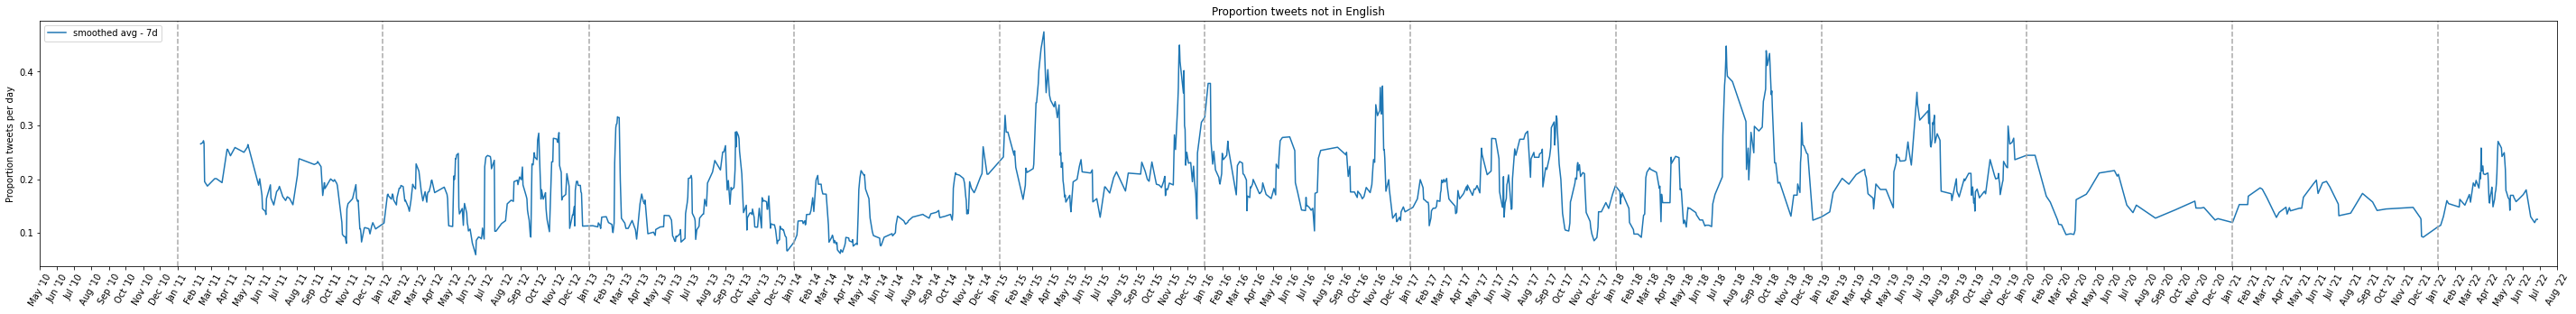

In [325]:
top_dict_other = plot_volume(language='other', freqs='D', plot_smooth_only=True, roll_window=7)

Removing tweets not in English, it's mostly translations of English tweets. We know that Twitter's automatic language detection is not great, so double-checking with langdetect and only including tweets tagged as English by both the default tagger and langdetect.

In [1523]:
df = df[(df['lang']=='en') & (df['lang_detected']=='en')]

Great, now let's fine tune some language models on these tweets for better performance (see pretrain script)

### Pretraining performance analysis

In [921]:
performances = pd.read_json('logs/pretraining/performances.jsonl', lines=True, orient='records')
performances['id'] = performances['name'].str.split('_').str[0]
performances['learning_rate'] = performances['name'].str.split('_').str[1].str.split('-').str[1].astype(float)
performances['batch_size'] = performances['name'].str.split('_').str[4].str.split('-').str[1].astype(int)
performances['warmup'] = performances['name'].str.split('_').str[5].str.split('-').str[1].astype(float)
performances['chunk_size'] = performances['name'].str.split('_').str[2].str.split('-').str[1].astype(float)

Let's first visualize the impact of learning rates.

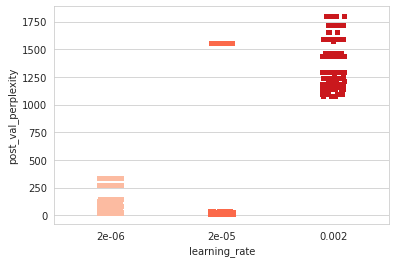

In [941]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='learning_rate', y='post_val_perplexity', 
              palette='Reds', 
              marker='s')
plt.show()

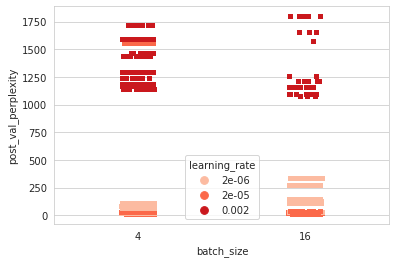

In [926]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='batch_size', y='post_val_perplexity', 
              hue='learning_rate',
              marker='s', palette='Reds')
plt.show()

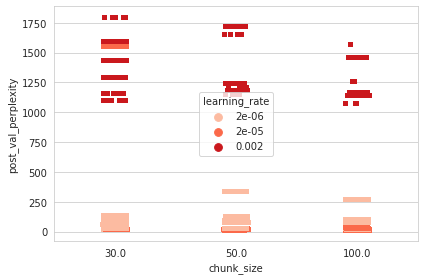

In [928]:
sns.stripplot(data=performances.sort_values(by='post_val_perplexity'), 
              x='chunk_size', y='post_val_perplexity', 
              hue='learning_rate',
              marker='s', palette='Reds')
plt.tight_layout()
plt.show()

Best learning rate seems to be univocally 2e-5, we'll go for batch_size=4 and chunk_size=100.

### Topic modeling preparation
Let's move on to modeling the topic of the tweets. We'll try to compare different modeling strategies, and both pretrained and fine-tuned models.
Then, we'll try to get an idea of what the evolution of topics has been over time. 
Let's start from comparing model metrics for multiple models, and parameter optimization configs.

#### Generate data

In [15]:
first_contextualized_run = False

In [16]:
if first_contextualized_run is True:
    topic_df = df[df['pretraining_splits']=='test'].sample(frac=1).reset_index()
    
    # Train test split
    import random
    random.seed(42)
    train_size = int(topic_df.shape[0] * .7)
    val_size = int(topic_df.shape[0] * .1)
    test_size = topic_df.shape[0] - train_size - val_size
    train_test = ['train'] * train_size + ['val'] * val_size + ['test'] * test_size
    random.shuffle(train_test)
    
    # Pretrained
    topic_df['topic_split'] = train_test 
    topic_df.to_json('processed/pre_topic_tweets.jsonl', lines=True, orient='records')

Training through `run_topics.py`

#### Model selection

In [17]:
topic_perf = pd.read_json('logs/topic/performances.jsonl', 
                          orient='records', 
                          lines=True)

In [18]:
def _preprocess_topic_performance(d):
    for k in ['vocab', 'bow', 'esize']:
        d[k] = d['name'].str.split(f'{k}-').str[1].str.split('_').str[0].astype(int)
    map_dict = {'comp': [8, 3],
                'lr': [11, 6],
                'batch': [10, 5]}
   
    def _get_name_substr(col, idx, n):
        return col.str.split('_').str[idx].str.lstrip(fr'{n}\-')
    
    def _match_finetuned_affix(col):
        return col.str.split('_').str[0].str.endswith(r'finetuned')
        
    def _make_col(n):
        return np.where(_match_finetuned_affix(d['name']), 
                        _get_name_substr(d['name'], map_dict[n][0], n),
                        _get_name_substr(d['name'], map_dict[n][1], n),).astype(float)
    
    d['components'] = _make_col('comp')
    d['lr_topic'] = _make_col('lr')
    d['batch_topic'] = _make_col('batch')
    d['lr_pretraining'] = np.where(_match_finetuned_affix(d['name']), 
                                   _get_name_substr(d['name'], 1, 'lr\-'),
                                   0).astype(float)
    d['unique_id'] = d['name'].str.split('_').str[0]
    for c in ['components', 'vocab', 'lr_topic', 'batch_topic']:
        d['unique_id'] = d['unique_id'] + f'_{c.split("_")[0]}-' + \
                         d[c].astype(str)
    d['unique_run'] = d['unique_id'] + '_run-' + d['run'].astype(str)    
    return d
    
    

In [19]:
topic_perf = _preprocess_topic_performance(topic_perf)

Plot performances

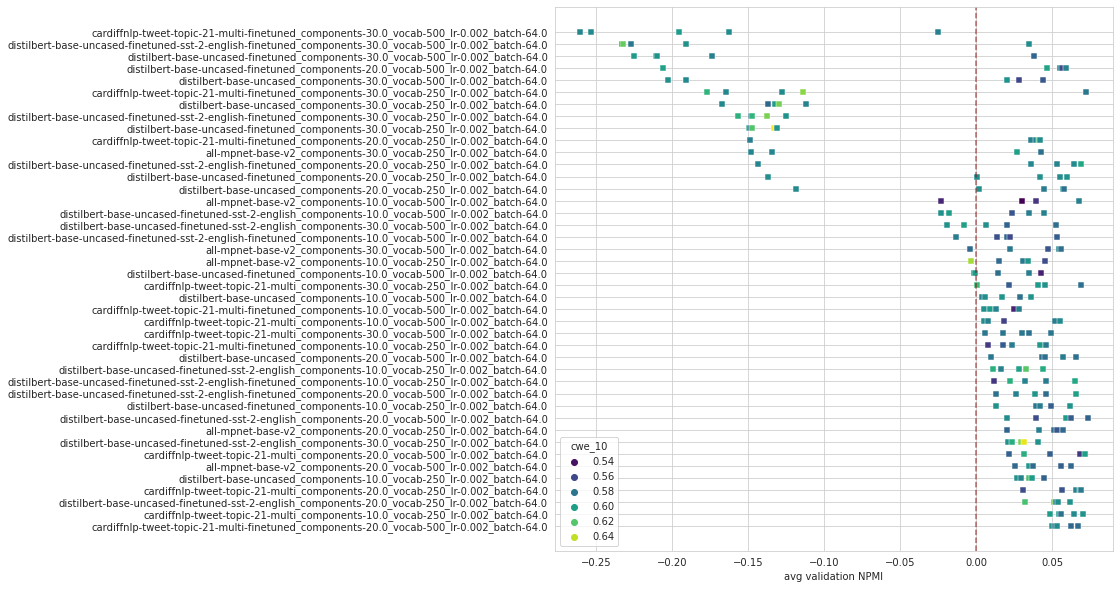

In [20]:
sns.set_style('whitegrid')
plt.subplots(figsize=(10,10))
plt.axvline(0, linestyle='--', color='darkred', alpha=.6)
sns.scatterplot(data=topic_perf.sort_values(by='test_npmi_10'), 
                y='unique_id', x=f'test_npmi_10', color='darkgrey',
               marker='s', hue='cwe_10', palette='viridis')
plt.xlabel('avg validation NPMI')
plt.ylabel('')
plt.show()

Save best models

In [21]:
grouped = topic_perf.groupby('unique_id').mean().reset_index().sort_values(by='val_npmi_10')
grouped = grouped.merge(topic_perf[['unique_id', 'name']].drop_duplicates())
grouped['id'] = grouped['name'].str.split('_vocab').str[0]
grouped = grouped.sort_values(by='val_npmi_10').tail(n=20)
grouped = grouped[['id', 'vocab', 'bow', 'esize', 'components', 'lr_topic', 'batch_topic']]
grouped.to_json('logs/topic/best_models.jsonl', lines=True, orient='records')

Now fitting and saving these models through `fit_topic_final.py`

### Pick final model

In [22]:
topic_perf = pd.read_json('logs/topic/performances_final.jsonl', 
                          orient='records', 
                          lines=True)

In [23]:
topic_perf = _preprocess_topic_performance(topic_perf)

In [24]:
topic_perf = topic_perf.sort_values(by='test_npmi_10', ascending=False).reset_index(drop=True)
topic_perf['top_npmi'] = (topic_perf.index < 20).astype(int) # 
topic_perf['npmi_rank'] = topic_perf.index
topic_perf = topic_perf.sort_values(by='cwe_10', ascending=False).reset_index(drop=True)
topic_perf['top_cwe'] = (topic_perf.index < 20).astype(int)
topic_perf['cwe_rank'] = topic_perf.index
topic_perf = topic_perf.sort_values(by='rbo_10', ascending=False).reset_index(drop=True)
topic_perf['top_rbo'] = (topic_perf.index < 20).astype(int)
topic_perf['rbo_rank'] = topic_perf.index

<ipython-input-25-176044cd6d63>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()


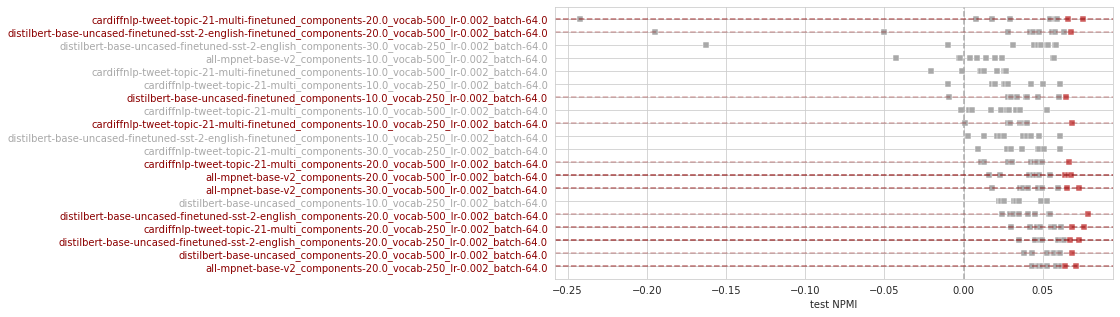

In [25]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,5))
plt.axvline(0, linestyle='--', color='darkgrey')
sns.scatterplot(data=topic_perf.sort_values(by='test_npmi_10'), 
                y='unique_id', x=f'test_npmi_10', 
                hue='top_npmi', 
                legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='test_npmi_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('test NPMI')
plt.ylabel('')
plt.show()

Compute extrinsic metrics

<ipython-input-26-aaa68f69c901>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()


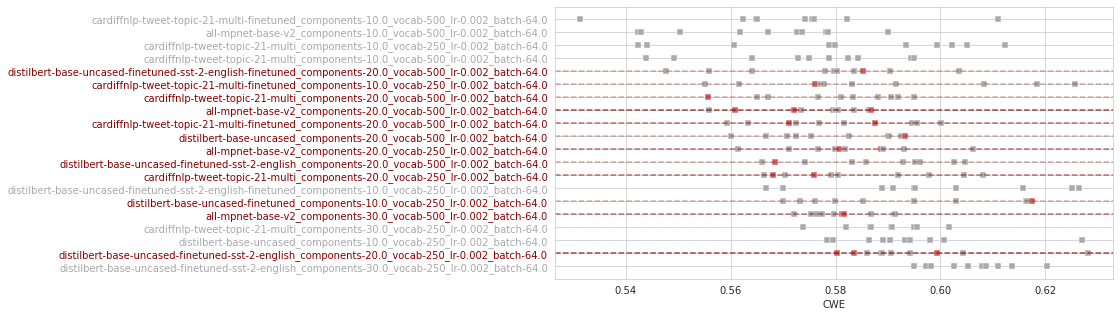

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=topic_perf.sort_values(by='cwe_10'), 
                y='unique_id', x=f'cwe_10', 
                hue='top_npmi', 
                legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='cwe_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('CWE')
plt.ylabel('')
plt.show()

<ipython-input-27-feabf69101d5>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()


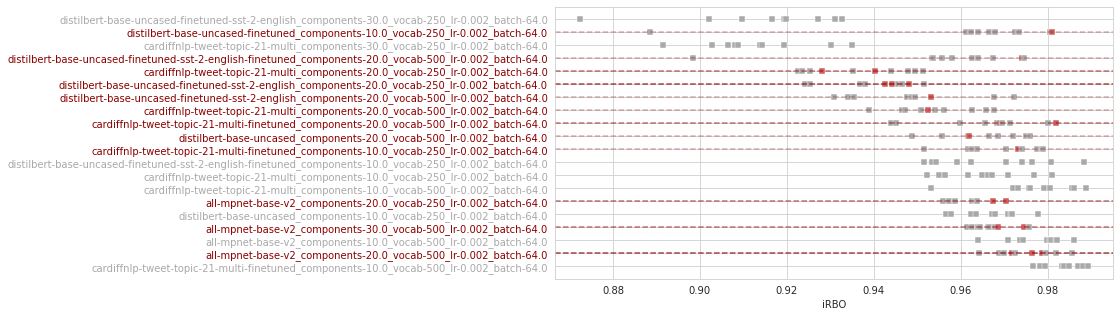

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=topic_perf.sort_values(by='rbo_10'), 
                y='unique_id', x=f'rbo_10', 
                hue='top_npmi', legend=False, 
                palette=['darkgrey', 'indianred'],
                marker='s')
best_names = topic_perf.sort_values(by='test_npmi_10')[topic_perf['top_npmi']==1].unique_id.tolist()
label_cols = ["darkred" if model_n in best_names else 'darkgrey' 
              for model_n in topic_perf.sort_values(by='rbo_10')["unique_id"].unique()]
[t.set_color(label_cols[i]) for i, t in enumerate(ax.yaxis.get_ticklabels())]
for v in best_names:
    plt.axhline(v, color='darkred', linestyle='--', alpha=.3)
plt.xlabel('iRBO')
plt.ylabel('')
plt.show()

### Analyze final model

In [224]:
top_npmi = list(zip(topic_perf[topic_perf['top_npmi']==1].sort_values(by='test_npmi_10', ascending=False).name.tolist(),
                    topic_perf[topic_perf['top_npmi']==1].sort_values(by='test_npmi_10', ascending=False).run.tolist()))

In [225]:
top_map = {}
for t in top_npmi:
    topics = json.load(open(f'logs/topic/{t[0]}/topic_map_{t[1]}.json'))
    top_map[f'{t[0]}_{t[1]}'] = topics

Best model - CardiffNLP tweet topic model, 250-dim vocab, 20 topics.

In [226]:
n_model = 0

print(top_npmi[n_model][0])
for t in range(30):
    try:
        print(f'Topic {t}')
        print(top_map[f'{top_npmi[n_model][0]}_{top_npmi[n_model][1]}'][f'{t}'])
    except:
        break

distilbert-base-uncased-finetuned-sst-2-english_vocab-500_bow-499_comp-20_esize-768_batch-64_lr-0.002_epochs-100_act-softplus
Topic 0
['recovery', 'energy', 'green', 'transition', 'nextgenerationeu', 'digital', 'innovation', 'research', 'projects', 'transport', 'billion', 'sustainable', 'help', 'resilience', 'plan', 'support', 'new', 'eugreendeal', 'climate', 'economy']
Topic 1
['new', 'climate', 'energy', 'eugreendeal', 'emissions', 'strategy', 'transition', 'economy', 'sustainable', 'green', 'digital', 'planet', 'europe', 'action', 'environment', 'clean', 'change', 'recovery', 'make', 'reduce']
Topic 2
['million', 'people', 'countries', 'support', 'humanitarian', 'help', 'coronavirus', 'eu', 'ukraine', 'strongertogether', 'standwithukraine', 'food', 'pandemic', 'need', 'vaccine', 'war', 'covid', 'assistance', 'medical', 'solidarity']
Topic 3
['quoted', 'euchat', 'story', 'live', 'storify', 'cet', 'chat', 'ask', 'twitter', 'watch', 'questions', 'join', 'tomorrow', 'follow', 'using', '

In [227]:
topic_20d = pd.read_json(f'logs/topic/{top_npmi[n_model][0]}/topic_preds_{top_npmi[n_model][1]}.jsonl',
                          orient='records', lines=True)
t = 7
print(top_map[f'{top_npmi[n_model][0]}_{top_npmi[n_model][1]}'][f'{t}'])
print('\nTweets')
display(topic_20d[topic_20d['topic_split']=='train'].sort_values(by=f'topic_{t}', ascending=False).head(n=10).text.tolist())

['statement', 'president', 'barrosoeu', 'following', 'barroso', 'minister', 'speech', 'meeting', 'remarks', 'ashton', 'vp', 'joint', 'council', 'vice', 'high', 'ep', 'euco', 'visit', 'un', 'summit']

Tweets


['Statement by @BarrosoEU following his meeting with Mr. Milo Djukanovic, Prime Minister of #Montenegro ',
 'Statement by President @BarrosoEU following his meeting with Mr Petr #Nečas, Prime Minister of the #CzechRepublic ',
 'Statement by #Barroso  following the meeting of the leaders of the #euro area ',
 'Statement by President @BarrosoEU following his meeting with Petro @poroshenko, President of #Ukraine: ',
 'Statement by President #Barroso following his meeting with Polish PM Donald #Tusk ',
 'Statement by President @BarrosoEU following his meeting with high-level religious leaders \n ',
 'Statement by President @BarrosoEU in #Prague ',
 'Statement by President @BarrosoEU following his meeting with philosophical and non-confessional organisations ',
 'Statement of President #Barroso following the meeting with the Russian Government ',
 'Statement by Pdt #Barroso following the meeting with Mr #Băsescu, President of #Romania ']

In [228]:
topic_20comp = ['digitalization_green_transition_and_recovery', 
                'climate_energy_and_sustainability', 
                'health_support',
                'storify',
                'citizens_initiative',
                'trade_justice_and_protection',
                'infographics',
                'post-summit_statements',
                'humanitarian_action',
                'strategic_investment', 
                'vaccines',
                'human_rights',
                'president_addresses',
                'finance_and_euro',
                'citizens_rights',
                'live_events',
                'institutional_statements',
                'consumer_rights_and_digital_policy',
                'future_or_the_eu',
                '@eu_commission']
exclude_20 = ['president_addresses',
              'infographics', 
              'post-summit_statements',
              'live_events',
              'storify',
              'institutional_statements', 
              '@eu_commission'] 

Load annotated dataset

In [229]:
for i in range(20):
    topic_20d = topic_20d.rename({f'topic_{i}': topic_20comp[i]}, axis=1)
topic_20d['top_topic'] = topic_20d[topic_20comp].apply(lambda x: topic_20comp[x.argmax()], 
                                                       axis=1)
topic_20d['confidence'] = topic_20d[topic_20comp].apply(lambda x: x.max(), axis=1)

In [230]:
from scipy.stats import entropy
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month', 'Y': 'year'}
figsizes = {'D': (50,5), 'W': (15,3), 'M': (10, 5), 'Y': (12,5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}

def plot_topic_volume(topic_list, metric='prop', freqs='D', roll_window=7):
    top_dict = None
    for freq in [freqs]:
        figsize = figsizes[freq] if len(topic_list)<=1 else (30,5)
        fig, ax = plt.subplots(figsize=figsize)
        grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
        if topic_20d['created_at'].dtype != 'datetime64':
            topic_20d['created_at'] = pd.to_datetime(topic_20d['created_at'], 
                                                     infer_datetime_format=True)
        if metric=='mean':
            grouped = topic_20d.drop_duplicates('text').groupby(grouper).mean().reset_index()
        else:
            grouped = topic_20d.drop_duplicates('text').groupby([grouper, 'top_topic']).count()
            grouped = grouped.reset_index()[['created_at', 
                                             'top_topic', 
                                             'index']].rename({'index': 'count'}, axis=1)
            top_per_unit = topic_20d.groupby(grouper).count()
            top_per_unit = top_per_unit.reset_index()[['created_at', 'index']].rename({'index': 'tot_count'},
                                                                                      axis=1)
            grouped = grouped.merge(top_per_unit)
            grouped['count'] = grouped['count'] / grouped['tot_count']
            if metric != 'entropy':
                grouped = grouped[['created_at', 
                                   'top_topic', 
                                   'count']].pivot(index='created_at', 
                                                   columns='top_topic', 
                                                   values='count').reset_index().fillna(0)
            else:
                grouped = grouped.groupby('created_at')['count'].agg(entropy).reset_index()
                grouped = grouped.rename({'count': 'entropy'}, axis=1)            
        if metric != 'entropy':    
            for t in topic_list:   
                if len(topic_list)<=1:
                    label=None
                    title=t
                else:
                    label=f'{t}'
                    title='Topic volume'
                grouped[f'{t}_smoothed'] = grouped[t].rolling(roll_window).mean()
                sns.lineplot(data=grouped, x='created_at', y=f'{t}_smoothed', 
                             label=label)
            plt.ylabel(f'Proportion tweets')
        else:
            grouped[f'entropy_smoothed'] = grouped['entropy'].rolling(roll_window).mean()
            sns.lineplot(data=grouped, x='created_at', y=f'entropy_smoothed', label=None)
            title='Entropy of topic distribution'
            top_dict = grouped[grouped['created_at'].apply(lambda x: x.year)>2011]
            top_dict = top_dict.sort_values(by='entropy').head(n=10).created_at.tolist()
        plt.xlabel('')
        plt.title(f'{title}')
        plt.xticks(rotation=60)
        # Make year boundaries
        for d in grouped.created_at.dt.year.unique()[1:]:
            plt.axvline(x=np.datetime64(f'{d}-01-01'), color='black', 
                                        linestyle='--', alpha=.3)
            plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'), 120), color='black')
        if freq != 'Y':
            ax.xaxis.set_major_locator(md.MonthLocator((1,7)))
            ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
        else:
            ax.xaxis.set_major_locator(md.YearLocator())
        plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
        plt.savefig(f'figures/topic_volume.pdf')
        plt.show()
    return top_dict

In [231]:
keeps = ['top_topic', 'text']
prop_topic = topic_20d.groupby('top_topic').agg(lambda x: x.count() / \
                                                topic_20d.shape[0]).reset_index()[keeps]
prop_topic['is_events'] = prop_topic['top_topic'].isin(exclude_20).astype(int)

#### Overall proportion of tweets per category

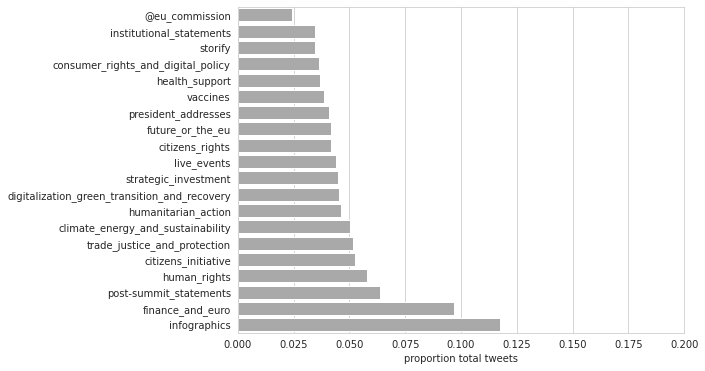

In [232]:
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=prop_topic[prop_topic['top_topic']!='maps_and_visuals'].sort_values(by='text'), 
            y='top_topic', x='text', color='darkgrey')
plt.xlabel('proportion total tweets')
plt.ylabel('')
plt.xlim(0, 0.2)
plt.show()

### Topic volume over time

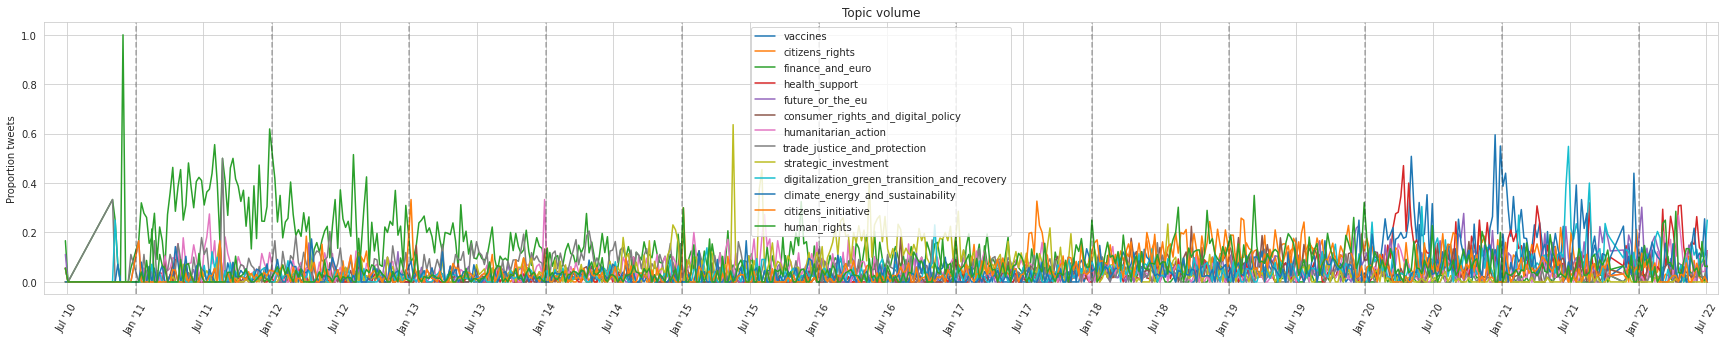

In [235]:
plot_topic_volume(set(topic_20comp) - set(exclude_20), 
                  freqs='W', 
                  roll_window=1)
plt.show()

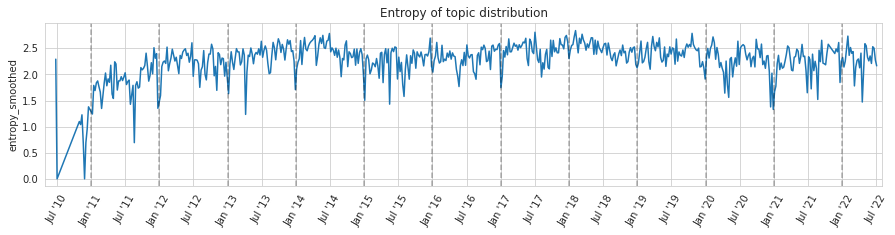

In [236]:
low_ent = plot_topic_volume([], 
                            metric='entropy',
                            freqs='W', 
                            roll_window=1)
plt.show()

In [39]:
#for l in low_ent:
#    print(l)
#    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
#                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].mean(axis=0)[topic_20comp].sort_values(ascending=False))
#    print('\n')

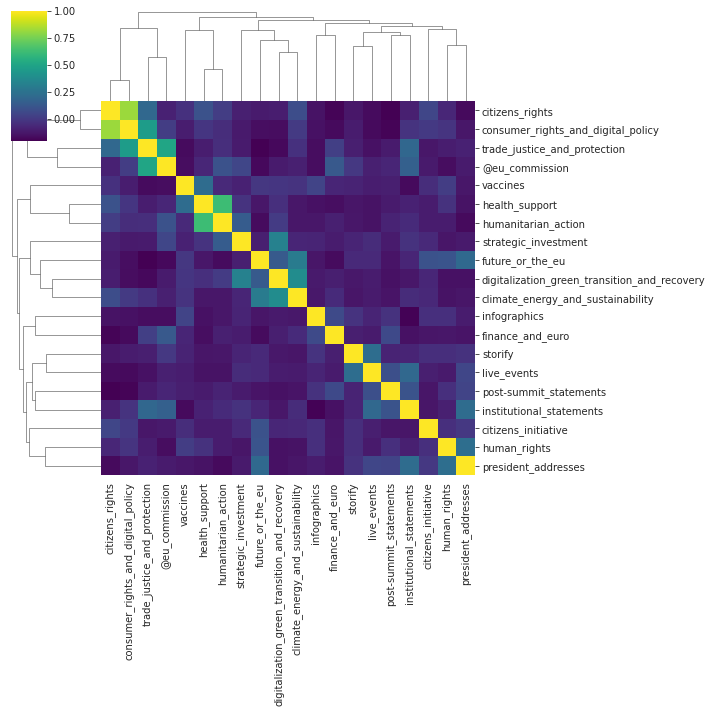

In [237]:
sns.clustermap(topic_20d[topic_20comp].corr(), cmap='viridis')

In [41]:
#for l in low_ent:
#    print(l)
#    display(topic_20d[((topic_20d['created_at'] - l).apply(lambda x: x.days) < 7) &
#                      ((topic_20d['created_at'] - l).apply(lambda x: x.days) >= 0)].groupby('top_topic').count()[['text']].sort_values(by='text', ascending=False))
#    print('\n')

Low-entropy weeks are associated to crisis moments (mainly COVID, Ukrainian crisis)

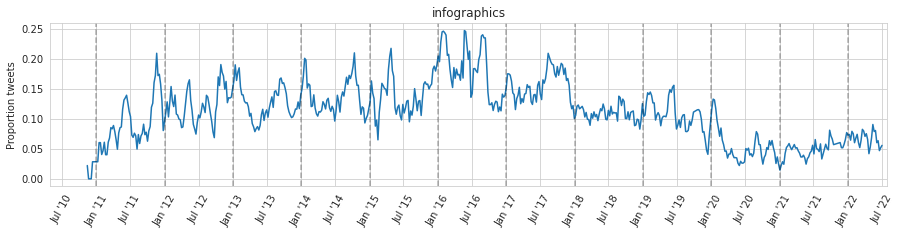

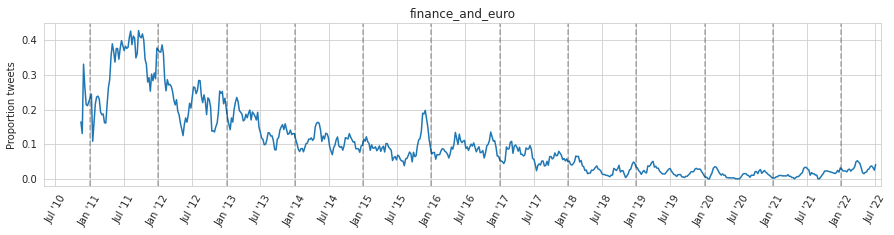

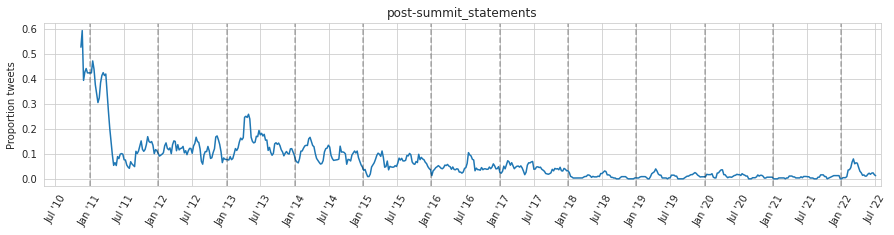

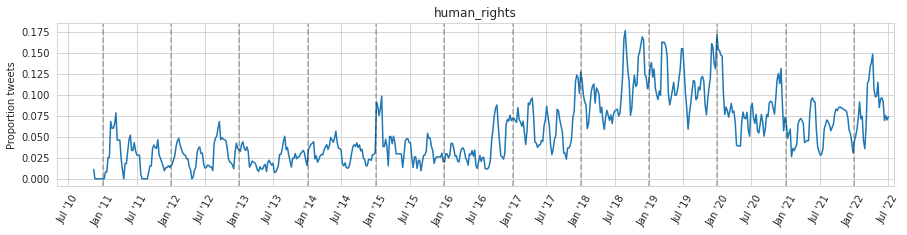

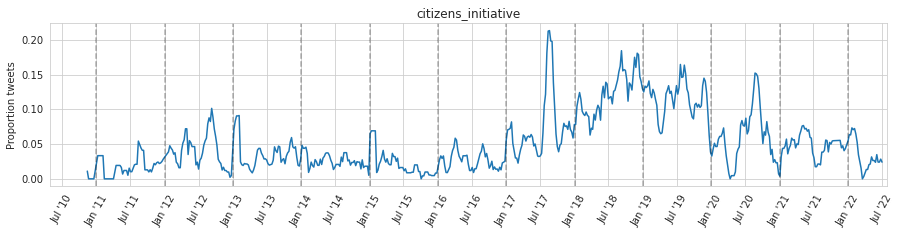

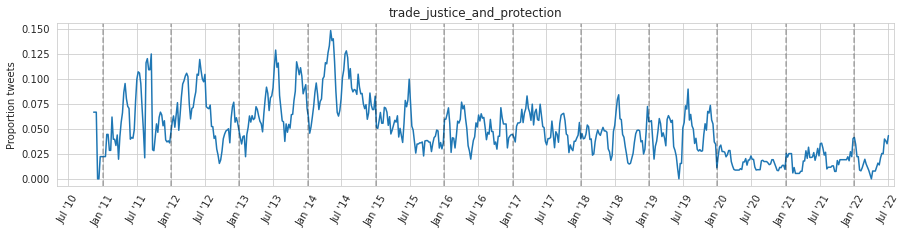

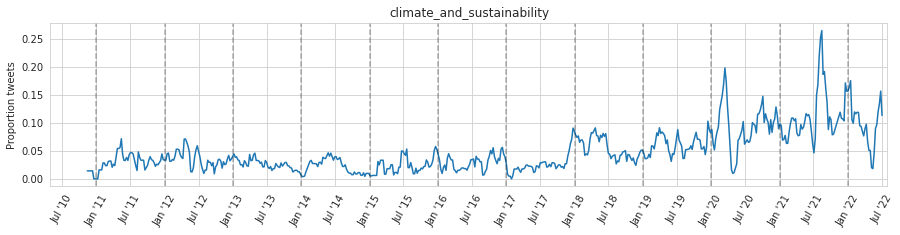

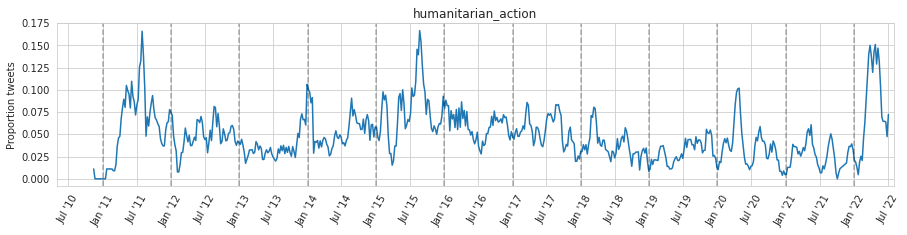

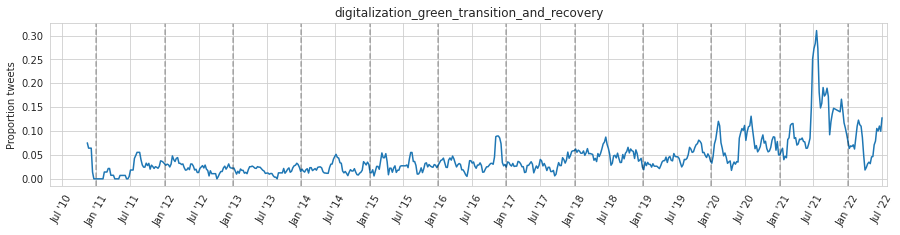

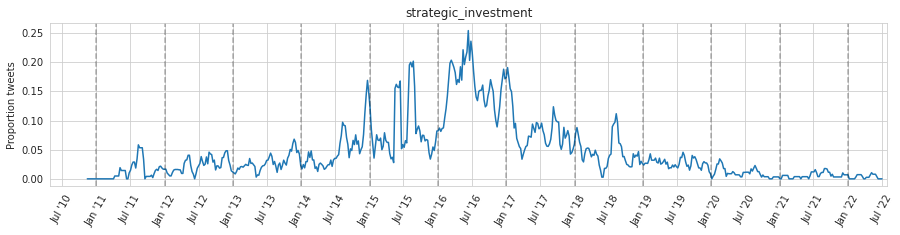

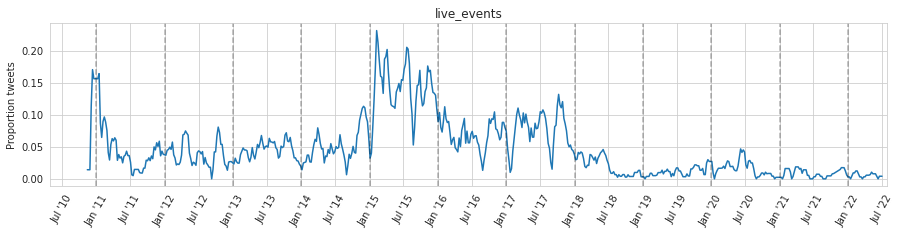

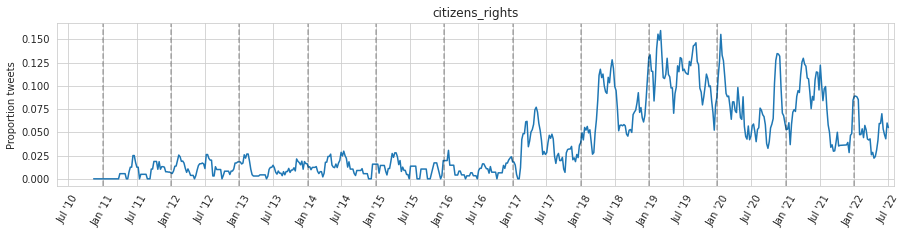

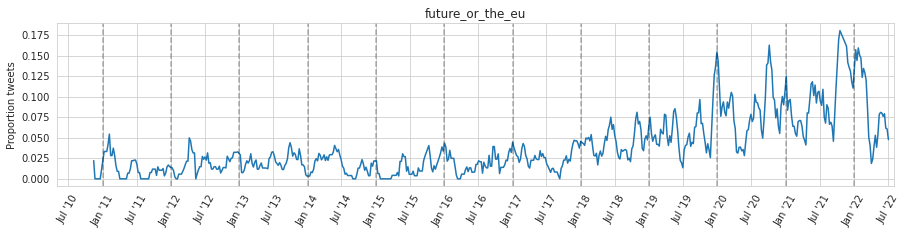

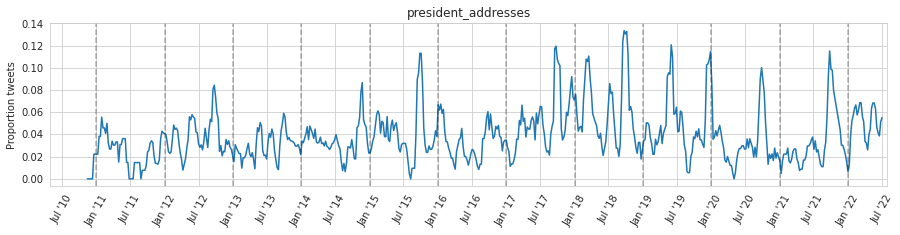

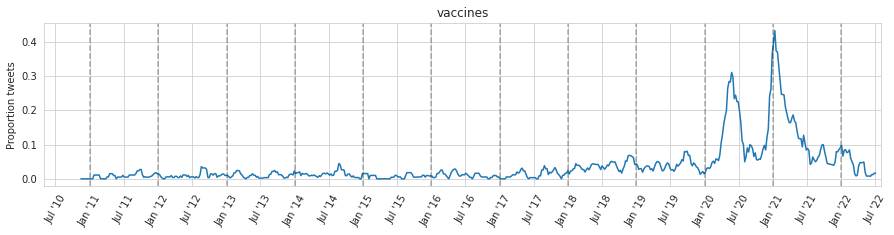

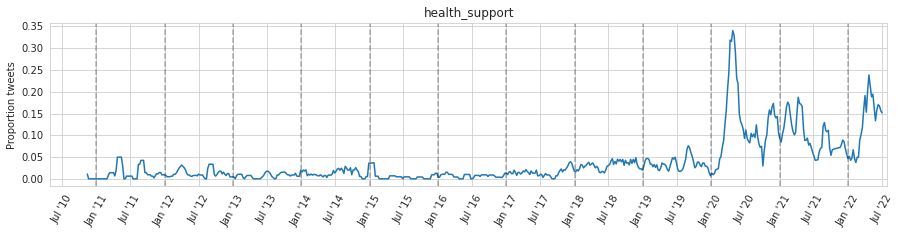

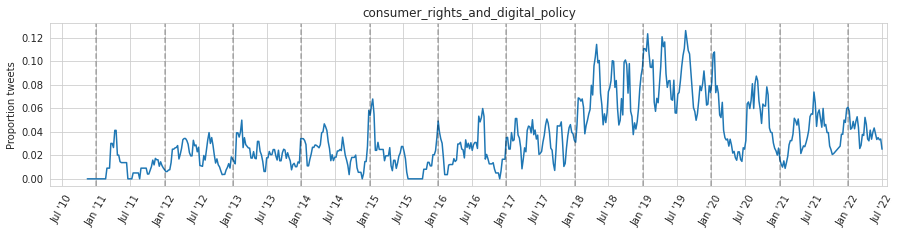

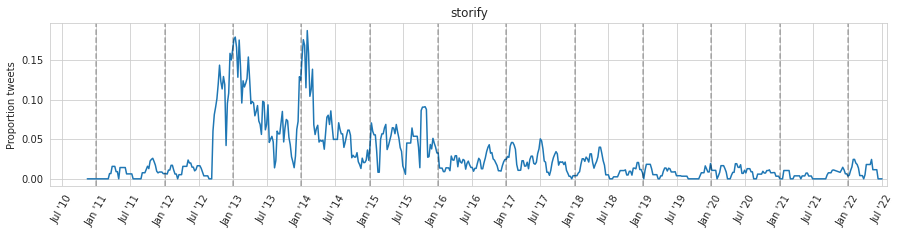

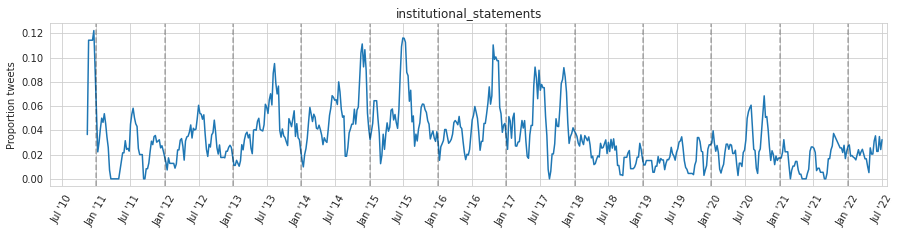

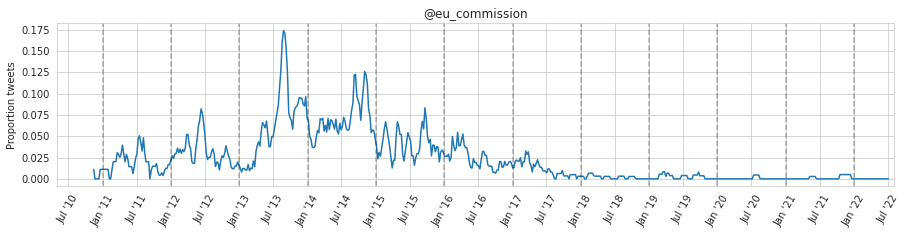

In [205]:
for t in prop_topic.sort_values(by='text', ascending=False).top_topic.tolist():
    plot_topic_volume([t], 
                      freqs='W', 
                      roll_window=5)
    plt.show()

### Engagement as a function of topic

In [206]:
aggs = topic_20d.groupby('top_topic')[['like_count', 
                                       'retweet_count', 
                                       'reply_count', 
                                       'quote_count']].agg('mean').reset_index()
aggs.columns = ['variable', 'mean_like', 'mean_rt', 'mean_reply', 'mean_quote']
top_likes = aggs.sort_values(by='mean_like').variable.tolist()
top_rts = aggs.sort_values(by='mean_rt').variable.tolist()
top_reply = aggs.sort_values(by='mean_reply').variable.tolist()
top_quote = aggs.sort_values(by='mean_quote').variable.tolist()

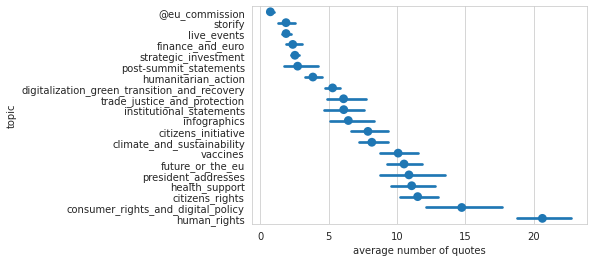

In [207]:
sns.pointplot(data=topic_20d,
               x='quote_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_quote)
plt.xlabel('average number of quotes')
plt.ylabel('topic')
plt.show()

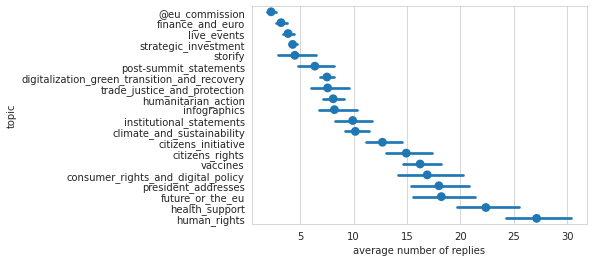

In [208]:
sns.pointplot(data=topic_20d,
               x='reply_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_reply,)
plt.xlabel('average number of replies')
plt.ylabel('topic')
plt.show()

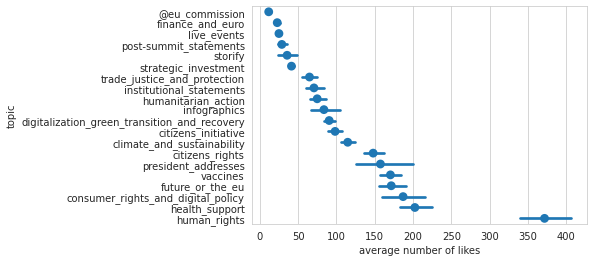

In [209]:
sns.pointplot(data=topic_20d, 
               x='like_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_likes)
plt.xlabel('average number of likes')
plt.ylabel('topic')
plt.show()

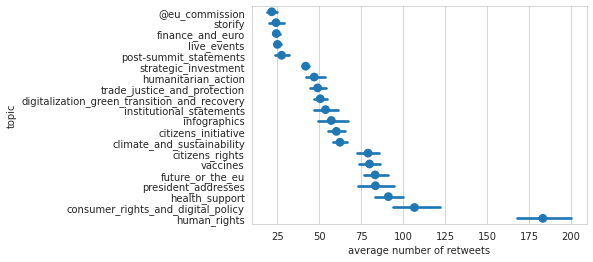

In [210]:
sns.pointplot(data=topic_20d, 
               x='retweet_count', y='top_topic',
              errorbar='sd', join=False,
              order = top_rts)
plt.xlabel('average number of retweets')
plt.ylabel('topic')
plt.show()

### Next steps
- Add predictions for new data
- Analyze comments
    - Get responses and link them to original tweets
    - Extract emotions
    - Plot emotion distribution by topic
- Highlight limitations 
    - Low-confidence predictions and bootstrapping
    - Low replicability